# Projeto de TCC
**Autor**: Igor Sousa dos Santos Santana

**Data**: 2024-07-26

## Índice

- [Importando pacotes e Bibliotecas](#importando-pacotes-e-bibliotecas)
- [Importando os Datasets](#importando-os-datasets)
- [Breve Apresentação dos Datasets](#breve-apresentacao-dos-datasets)
- [Breve Limpeza nos Datasets](./limpeza_dados.ipynb)
- [Análise Exploratória de Dados](./analise_exploratoria.ipynb)
- [Preparação dos parâmetros](#preparando-os-hiper-parâmetros)
- [Algoritmo KMeans](#utilizando-o-algoritmo-kmeans)
- [Algoritmo MeanShift](#utilizando-o-algoritmo-meanshift)
- [Algoritmo FuzzyCMeans](#usando-o-algoritmo-fuzzycmeans)
- [Bibliografia](#bibliografia)

## Importando pacotes e Bibliotecas

In [75]:
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import estimate_bandwidth
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from models import kmeans, meanshift
from utils import parametros
from fcmeans import FCM
import seaborn as sns
import pandas as pd
import numpy as np

## Importando os Datasets

In [76]:
df_iris_raw = pd.read_csv("./databases/raw/Iris.csv", sep = ",", index_col = "Id")
df_titanic_processed = pd.read_pickle("./databases/processed/titanic_processado.pkl")
df_coracao_processed = pd.read_pickle("./databases/processed/coracao_processado.pkl")

## Breve apresentacao dos datasets

In [77]:
df_iris_raw.sample(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
126,7.2,3.2,6.0,1.8,Iris-virginica
3,4.7,3.2,1.3,0.2,Iris-setosa
49,5.3,3.7,1.5,0.2,Iris-setosa
91,5.5,2.6,4.4,1.2,Iris-versicolor
78,6.7,3.0,5.0,1.7,Iris-versicolor
72,6.1,2.8,4.0,1.3,Iris-versicolor
67,5.6,3.0,4.5,1.5,Iris-versicolor
124,6.3,2.7,4.9,1.8,Iris-virginica
11,5.4,3.7,1.5,0.2,Iris-setosa


In [78]:
df_titanic_processed.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Fare,Embarked
PassengerId,,,,,,,,
670,1,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",0,28,1,52.000000,2
671,1,2,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",0,40,1,39.000000,2
789,1,3,"Dean, Master. Bertram Vere",1,1,1,20.575001,2
593,0,3,"Elsbury, Mr. William James",1,47,0,7.250000,2
499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,25,1,151.550003,2
444,1,2,"Reynaldo, Ms. Encarnacion",0,28,0,13.000000,2
298,0,1,"Allison, Miss. Helen Loraine",0,2,1,151.550003,2
293,0,2,"Levy, Mr. Rene Jacques",1,36,0,12.875000,0
149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",1,36,0,26.000000,2


In [79]:
df_coracao_processed.sample(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
14,58,0,3,150,283,1,0,162,0,1.0,2,0,2,1
87,46,1,1,101,197,1,1,156,0,0.0,2,0,3,1
144,76,0,2,140,197,0,2,116,0,1.1,1,0,2,1
125,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
216,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0
106,69,1,3,160,234,1,0,131,0,0.1,1,1,2,1
266,55,0,0,180,327,0,2,117,1,3.4,1,0,2,0
280,42,1,0,136,315,0,1,125,1,1.8,1,0,1,0
91,57,1,0,132,207,0,1,168,1,0.0,2,0,3,1


In [80]:
df_iris_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [81]:
df_titanic_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1473 entries, 1 to 724
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  1473 non-null   category
 1   Pclass    1473 non-null   category
 2   Name      1473 non-null   string  
 3   Sex       1473 non-null   category
 4   Age       1473 non-null   uint8   
 5   SibSp     1473 non-null   uint8   
 6   Fare      1473 non-null   float32 
 7   Embarked  1473 non-null   category
dtypes: category(4), float32(1), string(1), uint8(2)
memory usage: 37.6 KB


In [82]:
df_coracao_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 1 to 289
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       456 non-null    uint8   
 1   sex       456 non-null    category
 2   cp        456 non-null    category
 3   trestbps  456 non-null    uint8   
 4   chol      456 non-null    uint16  
 5   fbs       456 non-null    category
 6   restecg   456 non-null    category
 7   thalach   456 non-null    uint8   
 8   exang     456 non-null    category
 9   oldpeak   456 non-null    float32 
 10  slope     456 non-null    category
 11  ca        456 non-null    category
 12  thal      456 non-null    category
 13  target    456 non-null    category
dtypes: category(9), float32(1), uint16(1), uint8(3)
memory usage: 11.8 KB


## Preparando os hiper parâmetros

### Separando os **X** e **y** de todos os datasets

In [83]:
min_max_scaler = MinMaxScaler()

X_iris = df_iris_raw.drop(columns = ["Species"]).values
y_iris = df_iris_raw["Species"]

X_titanic = min_max_scaler.fit_transform(df_titanic_processed.drop(columns = ["Survived", "Name"]).values)
y_titanic = df_titanic_processed["Survived"]

X_coracao = min_max_scaler.fit_transform(df_coracao_processed.drop(columns = ["target"]).values)
y_coracao = df_coracao_processed["target"]

### Lendo os hiper-parametros de um arquivo e os salvando em uma classe

In [84]:
hiper_parametros_kmeans = parametros.ParametrosKmeans(path_arquivo_hiperparametros = "./hiperparametros/hiperparametros_kmeans.txt")
hiper_parametros_meanshift = parametros.ParametrosMeanshift(path_arquivo_hiperparametros = "./hiperparametros/hiperparametros_meanshift.txt")
hiper_parametros_cmeans = parametros.ParametrosCmeans(path_arquivo_hiperparametros = "./hiperparametros/hiperparametros_cmeans.txt")

## Utilizando o algoritmo Kmeans

In [85]:
soma_dos_quadrados_iris = []
soma_dos_quadrados_titanic = []
soma_dos_quadrados_coracao = []

for i in range(1, 14):
    Kmeans = kmeans.Kmeans(nro_clusters = i,
                           nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                           tolerancia = hiper_parametros_kmeans.getTolerancia(),
                           semente = hiper_parametros_kmeans.getSemente_randomica(),
                           fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                           algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
    Kmeans.fit(X_iris)
    soma_dos_quadrados_iris.append(Kmeans.getDistanciaAoQuadrado())
    
    Kmeans = kmeans.Kmeans(nro_clusters = i,
                           nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                           tolerancia = hiper_parametros_kmeans.getTolerancia(),
                           semente = hiper_parametros_kmeans.getSemente_randomica(),
                           fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                           algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
    Kmeans.fit(X_titanic)
    soma_dos_quadrados_titanic.append(Kmeans.getDistanciaAoQuadrado())
    
    Kmeans = kmeans.Kmeans(nro_clusters = i,
                           nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                           tolerancia = hiper_parametros_kmeans.getTolerancia(),
                           semente = hiper_parametros_kmeans.getSemente_randomica(),
                           fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                           algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
    Kmeans.fit(X_coracao)
    soma_dos_quadrados_coracao.append(Kmeans.getDistanciaAoQuadrado())

### Imprimindo o resultado dos testes

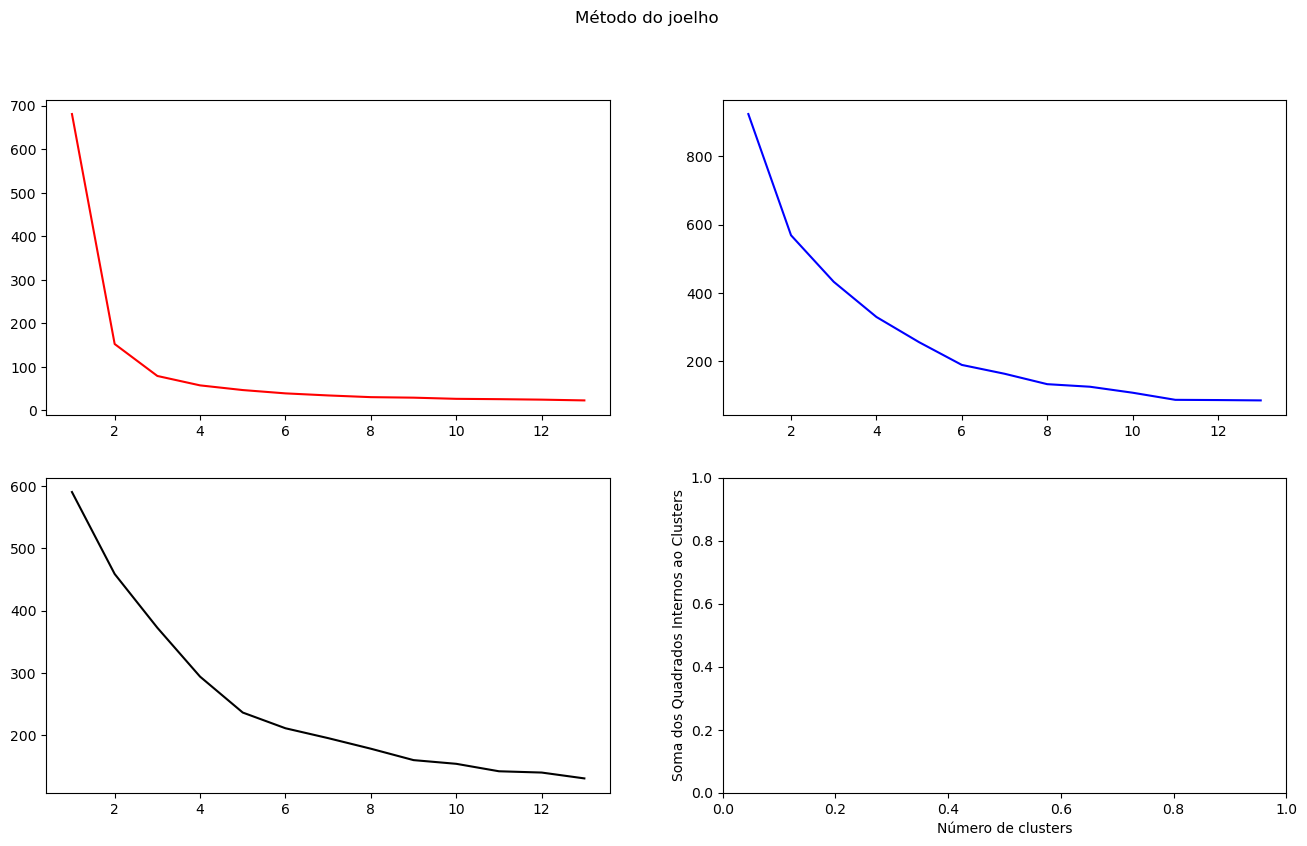

In [86]:
figura, eixos = plt.subplots(2, 2, figsize = (16, 9))

plt.suptitle("Método do joelho")
plt.xlabel("Número de clusters")
plt.ylabel("Soma dos Quadrados Internos ao Clusters")

eixos[0][0].plot(range(1, 14), soma_dos_quadrados_iris, color = "red")
eixos[0][1].plot(range(1, 14), soma_dos_quadrados_titanic, color = "blue")
eixos[1][0].plot(range(1, 14), soma_dos_quadrados_coracao, color = "black")

plt.show()

No caso acima, o resultado a partir do número 3 decai muito, portanto o número de clusters escolhido é:
- `3` para o dataset `Iris`;
- `2` para o dataset `Titanic`;
- `2` para o dataset `Coração`.

### Implementando a clusterização

#### Dataset Iris

In [87]:
kmeans_iris = kmeans.Kmeans(nro_clusters = 3,
                            nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                            tolerancia = hiper_parametros_kmeans.getTolerancia(),
                            semente = hiper_parametros_kmeans.getSemente_randomica(),
                            fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                            algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
y_kmeans_iris = kmeans_iris.fit_predict(X_iris)

#### Dataset Titanic

In [88]:
kmeans_titanic = kmeans.Kmeans(nro_clusters = 2,
                               nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                               tolerancia = hiper_parametros_kmeans.getTolerancia(),
                               semente = hiper_parametros_kmeans.getSemente_randomica(),
                               fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                               algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
y_kmeans_titanic = kmeans_titanic.fit_predict(X_titanic)

#### Dataset Coração

In [89]:
kmeans_coracao = kmeans.Kmeans(nro_clusters = 2,
                               nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                               tolerancia = hiper_parametros_kmeans.getTolerancia(),
                               semente = hiper_parametros_kmeans.getSemente_randomica(),
                               fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                               algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
y_kmeans_coracao = kmeans_coracao.fit_predict(X_coracao)

##### Visualizando os clusters

###### De forma 2D

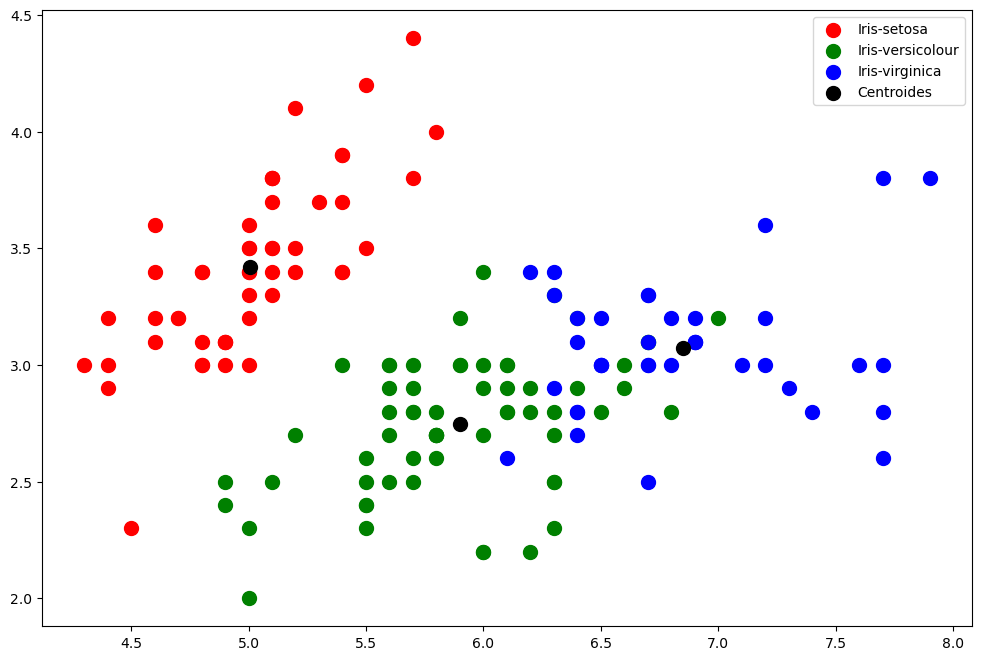

In [90]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_iris[y_kmeans_iris == 0, 0], X_iris[y_kmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_kmeans_iris == 1, 0], X_iris[y_kmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_kmeans_iris == 2, 0], X_iris[y_kmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans_iris.getCentroides()[:, 0], kmeans_iris.getCentroides()[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

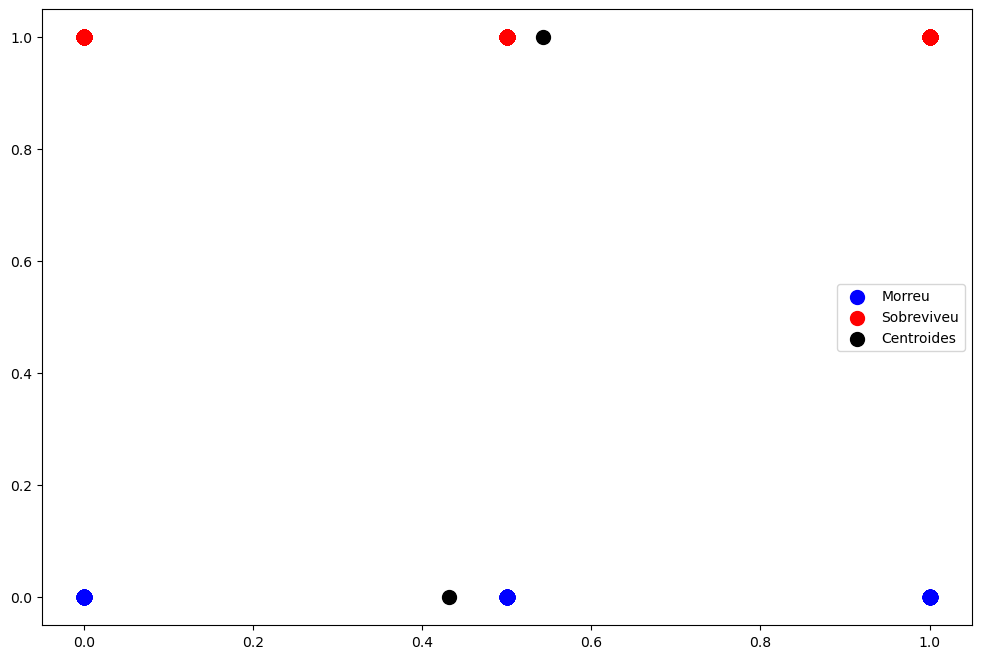

In [91]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_kmeans_titanic == 0, 0], X_titanic[y_kmeans_titanic == 0, 1], s = 100, c = "blue", label = "Morreu")
plt.scatter(X_titanic[y_kmeans_titanic == 1, 0], X_titanic[y_kmeans_titanic == 1, 1], s = 100, c = "red", label = "Sobreviveu")

### OS CENTROIDES
plt.scatter(kmeans_titanic.getCentroides()[:, 0], kmeans_titanic.getCentroides()[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

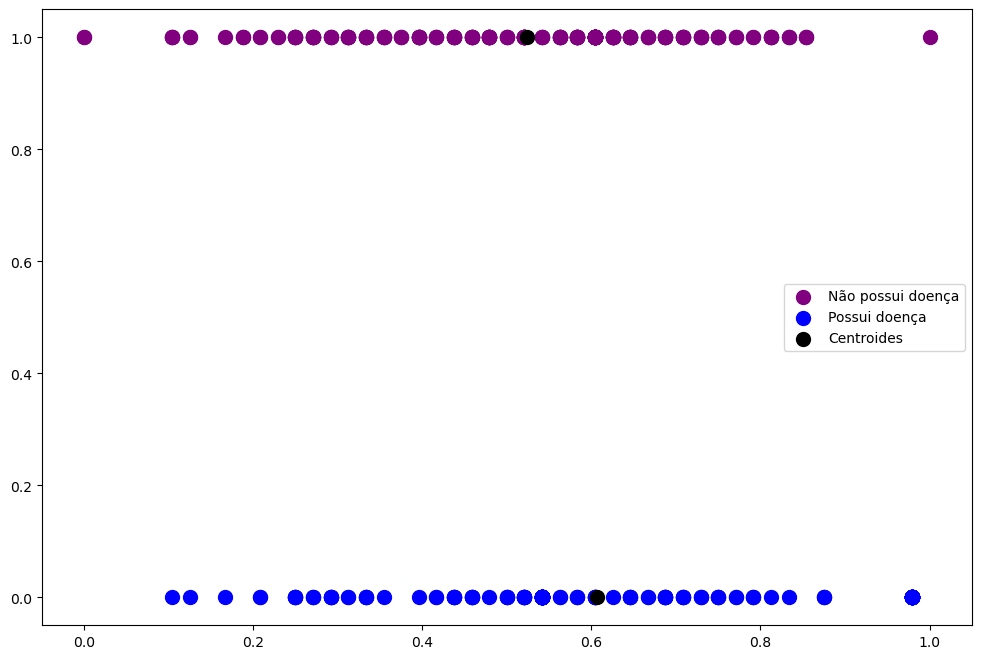

In [92]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_coracao[y_kmeans_coracao == 0, 0], X_coracao[y_kmeans_coracao == 0, 1], s = 100, c = "purple", label = "Não possui doença")
plt.scatter(X_coracao[y_kmeans_coracao == 1, 0], X_coracao[y_kmeans_coracao == 1, 1], s = 100, c = "blue", label = "Possui doença")

### OS CENTROIDES
plt.scatter(kmeans_coracao.getCentroides()[:, 0], kmeans_coracao.getCentroides()[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

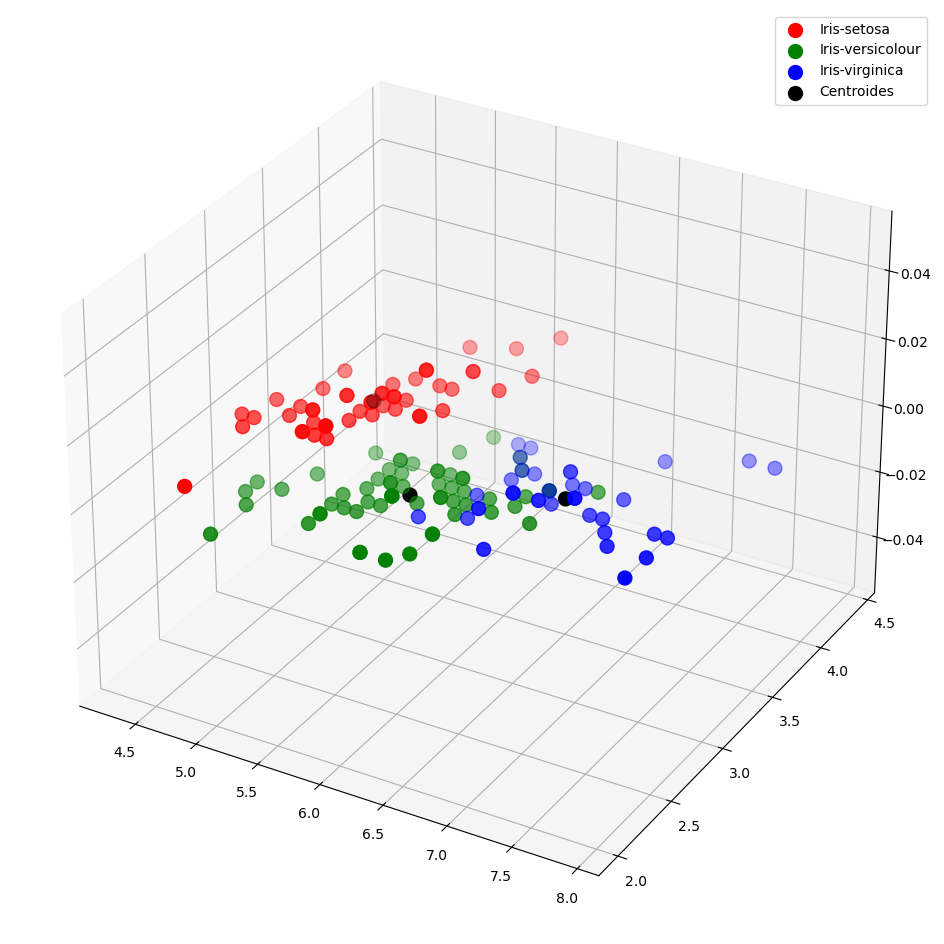

In [93]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_iris[y_kmeans_iris == 0, 0], X_iris[y_kmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_kmeans_iris == 1, 0], X_iris[y_kmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_kmeans_iris == 2, 0], X_iris[y_kmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans_iris.getCentroides()[:, 0], kmeans_iris.getCentroides()[:,1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

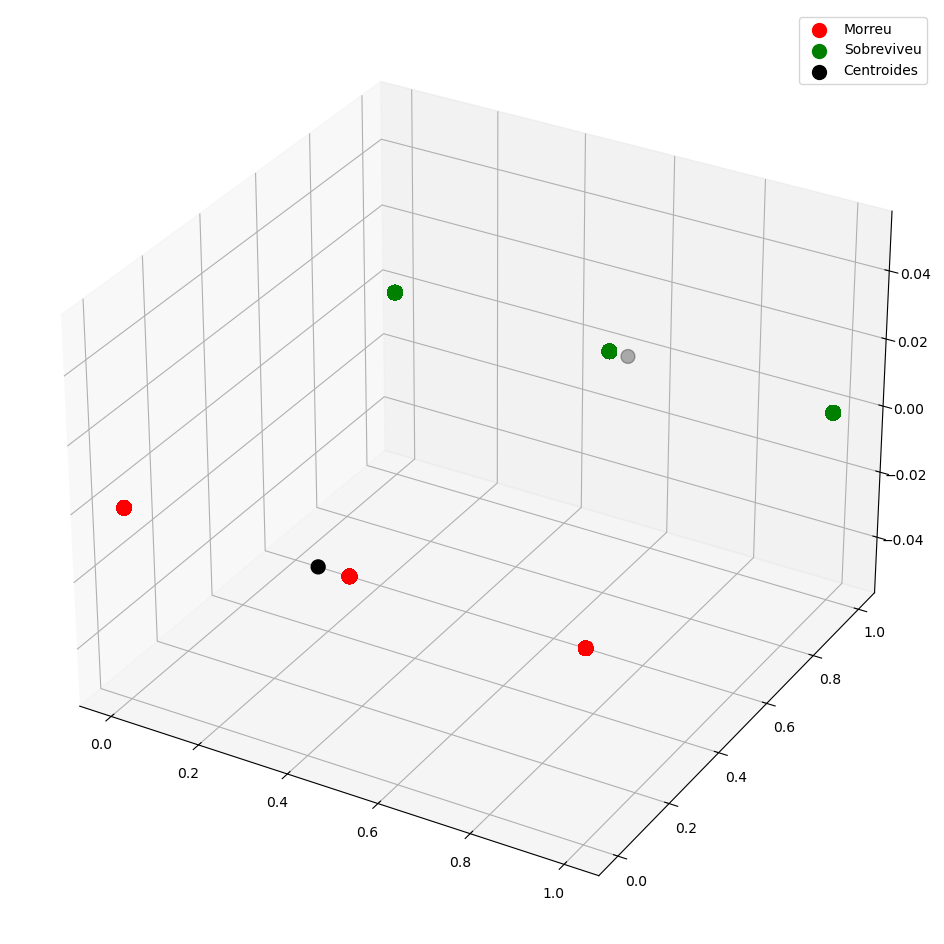

In [94]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_kmeans_titanic == 0, 0], X_titanic[y_kmeans_titanic == 0, 1], s = 100, c = "red", label = "Morreu")
plt.scatter(X_titanic[y_kmeans_titanic == 1, 0], X_titanic[y_kmeans_titanic == 1, 1], s = 100, c = "green", label = "Sobreviveu")

### OS CENTROIDES
plt.scatter(kmeans_titanic.getCentroides()[:, 0], kmeans_titanic.getCentroides()[:,1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

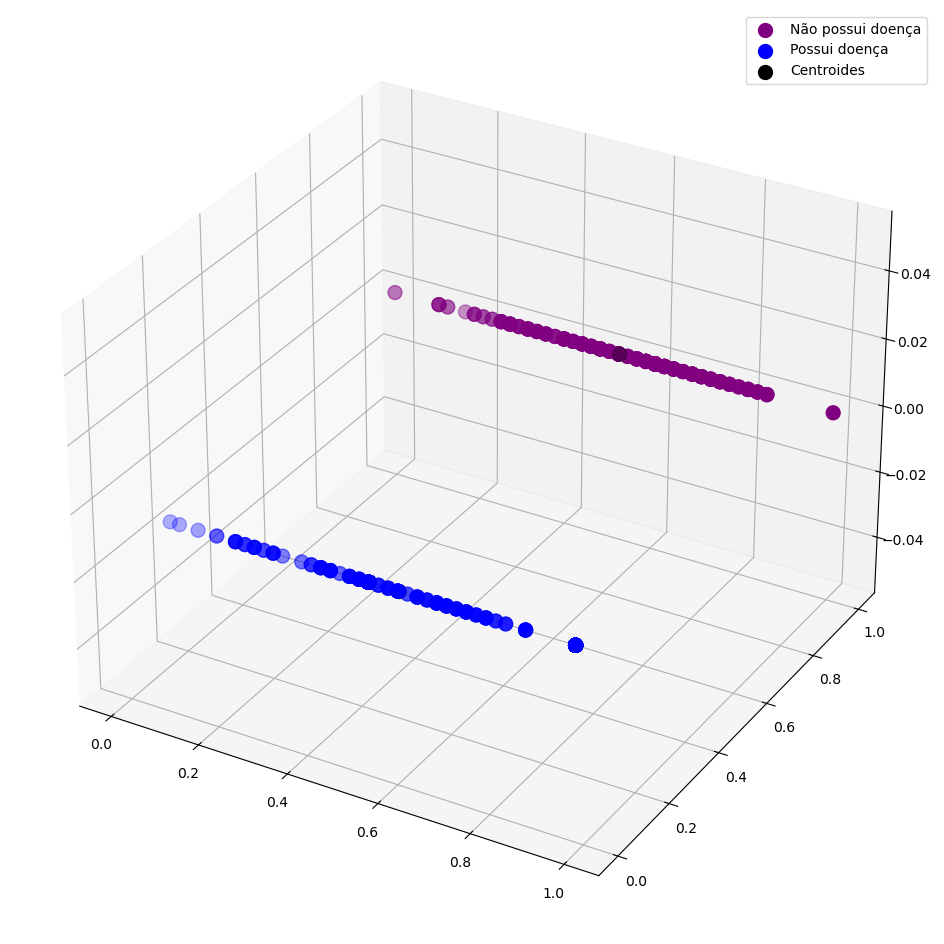

In [95]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_coracao[y_kmeans_coracao == 0, 0], X_coracao[y_kmeans_coracao == 0, 1], s = 100, c = "purple", label = "Não possui doença")
plt.scatter(X_coracao[y_kmeans_coracao == 1, 0], X_coracao[y_kmeans_coracao == 1, 1], s = 100, c = "blue", label = "Possui doença")

### OS CENTROIDES
plt.scatter(kmeans_coracao.getCentroides()[:, 0], kmeans_coracao.getCentroides()[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

##### Avaliação do método - Dataset Iris

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, train_size = 0.65, random_state = hiper_parametros_kmeans.getSemente_randomica())

kmeans_iris = kmeans.Kmeans(nro_clusters = 3,
                            nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                            tolerancia = hiper_parametros_kmeans.getTolerancia(),
                            semente = hiper_parametros_kmeans.getSemente_randomica(),
                            fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                            algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
y_kmeans_iris = kmeans_iris.fit(X_train)

# POSSIVEIS METRICAS
# ‘cityblock’,
# ‘cosine’,
# ‘euclidean’,
# ‘l1’,
# ‘l2’,
# ‘manhattan’

silhouette = []

for metrica in ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]:
    silhouette.append(silhouette_score(X_train, kmeans_iris.getLabels(), metric = metrica))

davies_bouldin = davies_bouldin_score(X_train, kmeans_iris.getLabels())
print("SILHOUETTE SCORE: ", silhouette, end = "\n")
print("DAVIS-BOULDIN SCORE: ", davies_bouldin, end = "\n")

SILHOUETTE SCORE:  [0.5474853348994807, 0.48802877100381326, 0.5439819212386819, 0.5474853348994807, 0.5439819212386819, 0.5474853348994807]
DAVIS-BOULDIN SCORE:  0.6563478438075016


##### Avaliação do método - Dataset Titanic

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, train_size = 0.65, random_state = hiper_parametros_kmeans.getSemente_randomica())

kmeans_titanic = kmeans.Kmeans(nro_clusters = 2,
                                nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                                tolerancia = hiper_parametros_kmeans.getTolerancia(),
                                semente = hiper_parametros_kmeans.getSemente_randomica(),
                                fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                                algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
y_kmeans_titanic = kmeans_titanic.fit(X_train)

# POSSIVEIS METRICAS
# ‘cityblock’,
# ‘cosine’,
# ‘euclidean’,
# ‘l1’,
# ‘l2’,
# ‘manhattan’

silhouette = []

for metrica in ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]:
    silhouette.append(silhouette_score(X_train, kmeans_titanic.getLabels(), metric = metrica))

davies_bouldin = davies_bouldin_score(X_train, kmeans_titanic.getLabels())
print("SILHOUETTE SCORE: ", silhouette, end = "\n")
print("DAVIS-BOULDIN SCORE: ", davies_bouldin, end = "\n")

SILHOUETTE SCORE:  [0.48239054797757, 0.5489398779208984, 0.4176574168973989, 0.48239054797757, 0.4176574168973989, 0.48239054797757]
DAVIS-BOULDIN SCORE:  1.1369415311735744


##### Avaliação do método - Dataset Coração

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_coracao, y_coracao, train_size = 0.65, random_state = hiper_parametros_kmeans.getSemente_randomica())

kmeans_coracao = kmeans.Kmeans(nro_clusters = 2,
                               nro_max_iteracao = hiper_parametros_kmeans.getNro_maximo_iteracoes(),
                               tolerancia = hiper_parametros_kmeans.getTolerancia(),
                               semente = hiper_parametros_kmeans.getSemente_randomica(),
                               fazer_copia = hiper_parametros_kmeans.getFazer_copia(),
                               algoritmo = hiper_parametros_kmeans.getAlgoritmo_kmeans())
y_kmeans_coracao = kmeans_coracao.fit(X_train)

# POSSIVEIS METRICAS
# ‘cityblock’,
# ‘cosine’,
# ‘euclidean’,
# ‘l1’,
# ‘l2’,
# ‘manhattan’

silhouette = []

for metrica in ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]:
    silhouette.append(silhouette_score(X_train, kmeans_coracao.getLabels(), metric = metrica))

davies_bouldin = davies_bouldin_score(X_train, kmeans_coracao.getLabels())
print("SILHOUETTE SCORE: ", silhouette, end = "\n")
print("DAVIS-BOULDIN SCORE: ", davies_bouldin, end = "\n")

SILHOUETTE SCORE:  [0.27349613578099097, 0.3704616412315266, 0.23838986879813837, 0.27349613578099097, 0.23838986879813837, 0.27349613578099097]
DAVIS-BOULDIN SCORE:  1.8105346369170232


## Utilizando o algoritmo Meanshift

In [99]:
# IRIS
bandwidth = estimate_bandwidth(X_iris, quantile = hiper_parametros_meanshift.getQuantil(),
                               n_samples = hiper_parametros_meanshift.getQtd_amostras(),
                               random_state = hiper_parametros_meanshift.getSemente_randomica())

meanShift_iris = meanshift.Meanshift(bandwidth = bandwidth,
                                     sementes = None,
                                     usar_versao_discreta_pontos = hiper_parametros_meanshift.getUsar_versao_discreta_pontos(),
                                     frequencia_minima = hiper_parametros_meanshift.getFrequencia_minima(),
                                     clusterizar_todos_pontos = hiper_parametros_meanshift.getClusterizar_todos_pontos(),
                                     nro_threads = hiper_parametros_meanshift.getNro_threads(),
                                     nro_max_iteracoes = hiper_parametros_meanshift.getNro_max_iteracoes())
meanShift_iris.fit(X_iris)

labels_iris = meanShift_iris.getLabels()
centros_iris = meanShift_iris.getCentroides()
###############################################

###############################################
# TITANIC
bandwidth = estimate_bandwidth(X_titanic, quantile = hiper_parametros_meanshift.getQuantil(),
                               n_samples = hiper_parametros_meanshift.getQtd_amostras(),
                               random_state = hiper_parametros_meanshift.getSemente_randomica())

meanShift_titanic = meanshift.Meanshift(bandwidth = bandwidth,
                                        sementes = None,
                                        usar_versao_discreta_pontos = hiper_parametros_meanshift.getUsar_versao_discreta_pontos(),
                                        frequencia_minima = hiper_parametros_meanshift.getFrequencia_minima(),
                                        clusterizar_todos_pontos = hiper_parametros_meanshift.getClusterizar_todos_pontos(),
                                        nro_threads = hiper_parametros_meanshift.getNro_threads(),
                                        nro_max_iteracoes = hiper_parametros_meanshift.getNro_max_iteracoes())
meanShift_titanic.fit(X_titanic)

labels_titanic = meanShift_titanic.getLabels()
centros_titanic = meanShift_titanic.getCentroides()
###############################################

###############################################
# CORAÇÃO
bandwidth = estimate_bandwidth(X_coracao, quantile = hiper_parametros_meanshift.getQuantil(),
                               n_samples = hiper_parametros_meanshift.getQtd_amostras(),
                               random_state = hiper_parametros_meanshift.getSemente_randomica())

meanShift_coracao = meanshift.Meanshift(bandwidth = bandwidth,
                                        sementes = None,
                                        usar_versao_discreta_pontos = hiper_parametros_meanshift.getUsar_versao_discreta_pontos(),
                                        frequencia_minima = hiper_parametros_meanshift.getFrequencia_minima(),
                                        clusterizar_todos_pontos = hiper_parametros_meanshift.getClusterizar_todos_pontos(),
                                        nro_threads = hiper_parametros_meanshift.getNro_threads(),
                                        nro_max_iteracoes = hiper_parametros_meanshift.getNro_max_iteracoes())
meanShift_coracao.fit(X_coracao)

labels_coracao = meanShift_coracao.getLabels()
centros_coracao = meanShift_coracao.getCentroides()

### Visualizando os Resultados

In [100]:
print(f"Quantidade de labels [iris]\t= {len(centros_iris)}", end = "\n")
print(f"Quantidade de labels [titanic]\t= {len(centros_titanic)}", end = "\n")
print(f"Quantidade de labels [coração]\t= {len(centros_coracao)}", end = "\n")

Quantidade de labels [iris]	= 2
Quantidade de labels [titanic]	= 3
Quantidade de labels [coração]	= 1


### Visualizando os resultados de forma gráfica

#### Dataset Iris

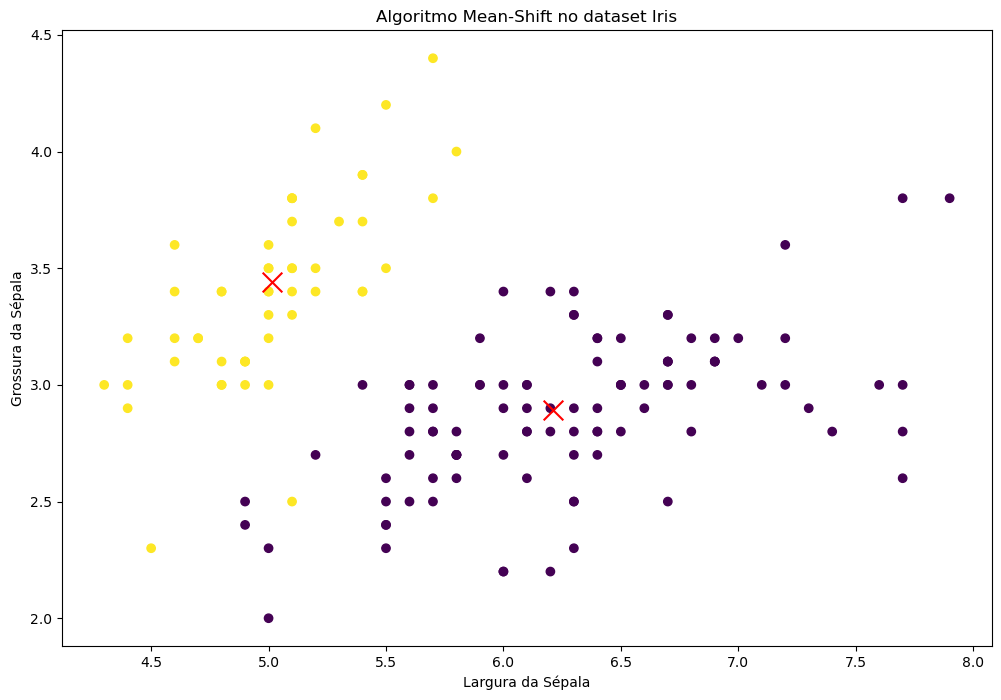

In [101]:
plt.figure(figsize = (12, 8))

plt.scatter(X_iris[:, 0], X_iris[:, 1], c = labels_iris)
plt.scatter(centros_iris[:, 0], centros_iris[:, 1], marker = "x", color = "red", s = 200)
plt.xlabel("Largura da Sépala")
plt.ylabel("Grossura da Sépala")
plt.title("Algoritmo Mean-Shift no dataset Iris")

plt.show()

#### Dataset Titanic

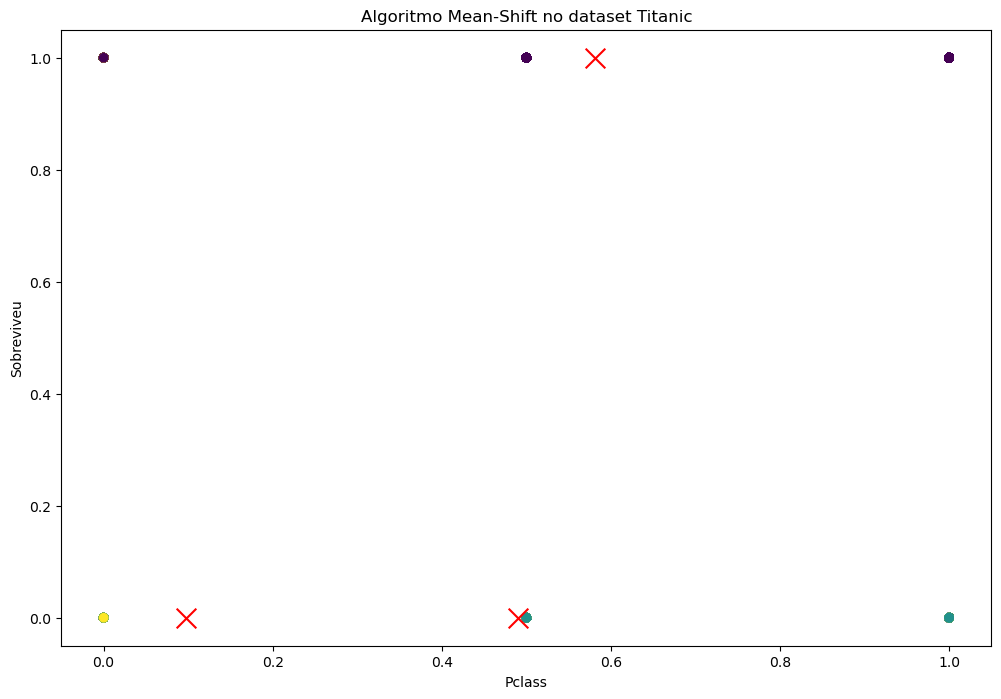

In [102]:
plt.figure(figsize = (12, 8))

plt.scatter(X_titanic[:, 0], X_titanic[:, 1], c = labels_titanic)
plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], marker = "x", color = "red", s = 200)
plt.xlabel("Pclass")
plt.ylabel("Sobreviveu")
plt.title("Algoritmo Mean-Shift no dataset Titanic")

plt.show()

#### Dataset Coração

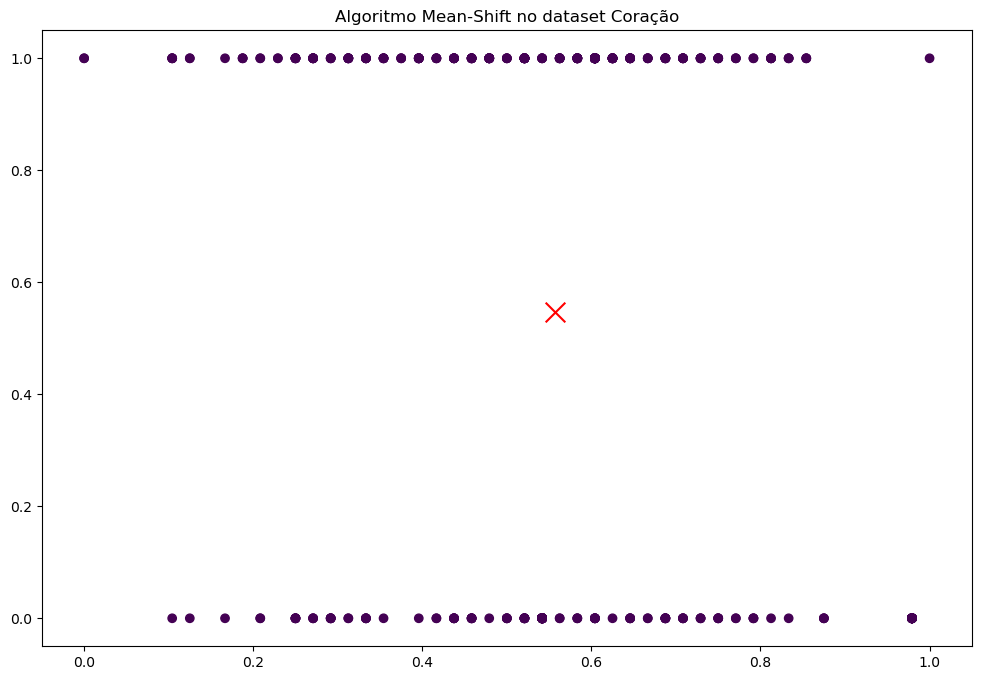

In [103]:
plt.figure(figsize = (12, 8))

plt.scatter(X_coracao[:, 0], X_coracao[:, 1], c = labels_coracao)
plt.scatter(centros_coracao[:, 0], centros_coracao[:, 1], marker = "x", color = "red", s = 200)
plt.title("Algoritmo Mean-Shift no dataset Coração")

plt.show()

## Usando o algoritmo FuzzyCMeans

### Imprimindo o resultado dos testes - Dataset Iris

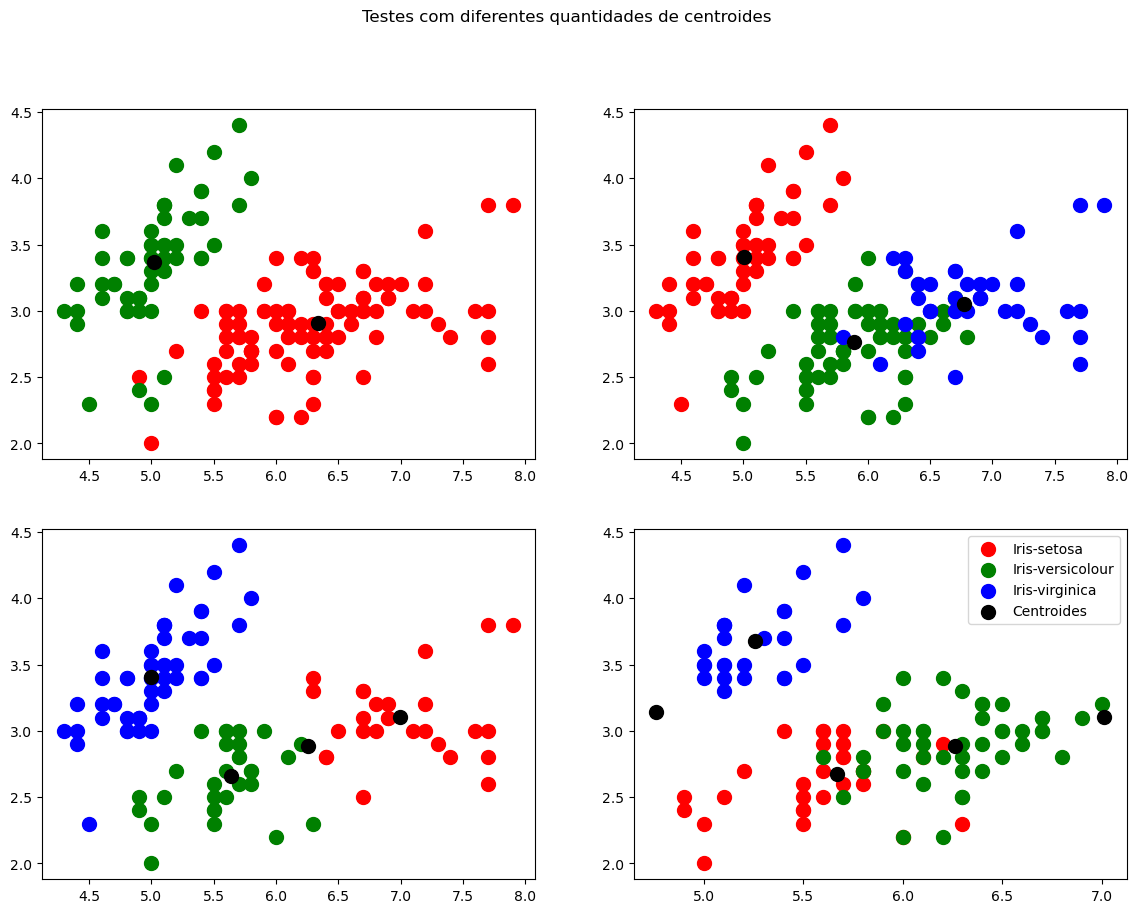

In [104]:
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = i,
                 m = hiper_parametros_cmeans.getParametro_fuzzy(),
                 max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                 distance = hiper_parametros_cmeans.getDistancia(),
                 randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                 error = hiper_parametros_cmeans.getTolerancia(),
                 trained = hiper_parametros_cmeans.getModelo_treinado(),
                 n_jobs = hiper_parametros_cmeans.getNro_threads())

    cmeans.fit(X_iris)
    y_cmeans = cmeans.predict(X_iris)
    centros = cmeans.centers
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_iris[y_cmeans == 0, 0], X_iris[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
    eixos[j][k].scatter(X_iris[y_cmeans == 1, 0], X_iris[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
    eixos[j][k].scatter(X_iris[y_cmeans == 2, 0], X_iris[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, valor 3 é o que melhor descreve o conjunto dos pontos. Então será escolhido 3 como parâmetro para futuros testes no modelo

### Implementando a clusterização - Dataset Iris

In [121]:
nro_de_clusters = 3

cmeans_iris = FCM(n_clusters = nro_de_clusters,
                  m = hiper_parametros_cmeans.getParametro_fuzzy(),
                  max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                  distance = hiper_parametros_cmeans.getDistancia(),
                  randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                  error = hiper_parametros_cmeans.getTolerancia(),
                  trained = hiper_parametros_cmeans.getModelo_treinado(),
                  n_jobs = hiper_parametros_cmeans.getNro_threads())

cmeans_iris.fit(X_iris)
y_cmeans_iris = cmeans_iris.predict(X_iris)
centros_iris = cmeans_iris.centers

##### Visualizando os clusters

###### De forma 2D

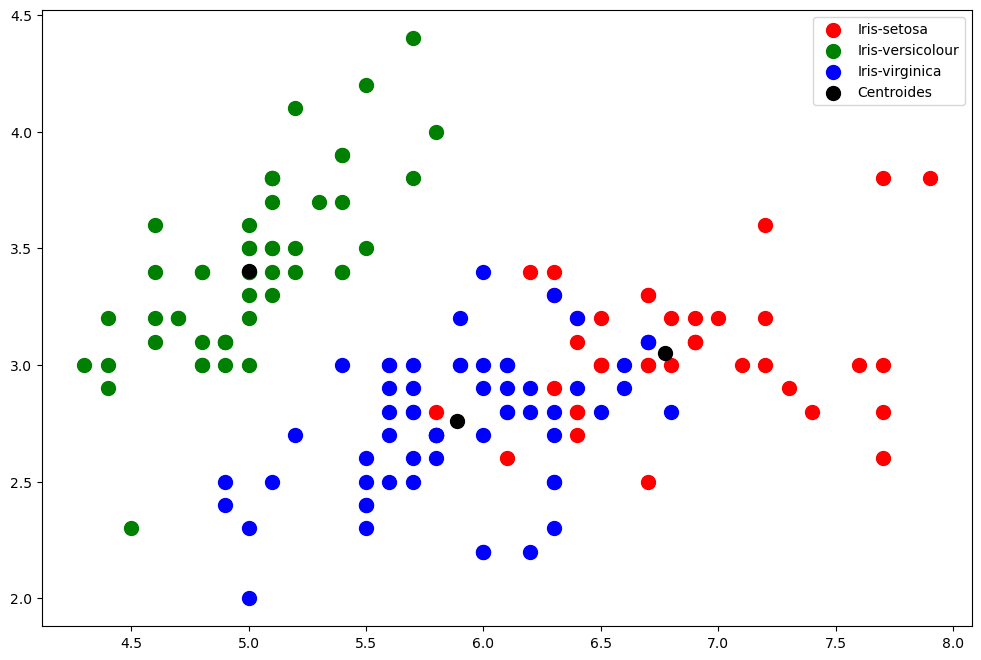

In [122]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_iris[y_cmeans_iris == 0, 0], X_iris[y_cmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_cmeans_iris == 1, 0], X_iris[y_cmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_cmeans_iris == 2, 0], X_iris[y_cmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES

plt.scatter(centros_iris[:, 0], centros_iris[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

### Imprimindo o resultado dos testes - Dataset Titanic

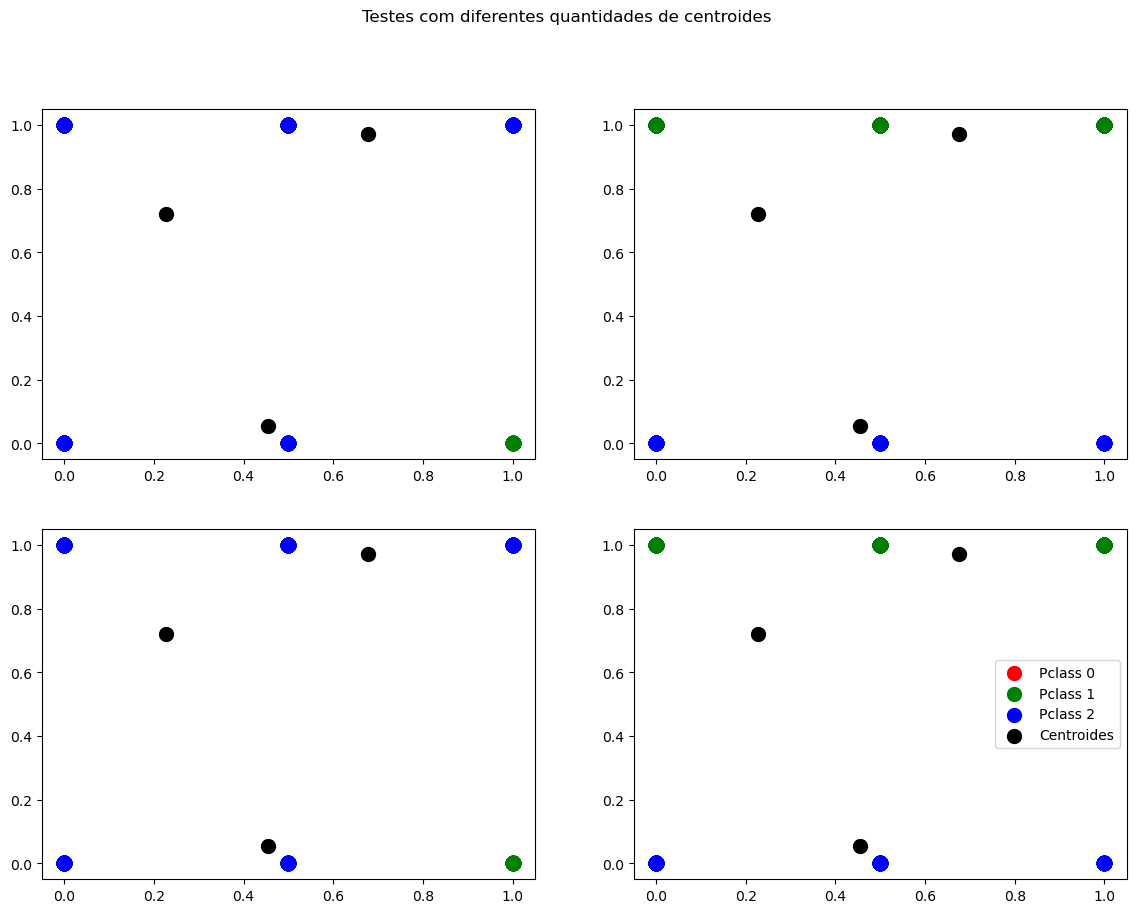

In [124]:
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = nro_de_clusters,
                 m = hiper_parametros_cmeans.getParametro_fuzzy(),
                 max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                 distance = hiper_parametros_cmeans.getDistancia(),
                 randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                 error = hiper_parametros_cmeans.getTolerancia(),
                 trained = hiper_parametros_cmeans.getModelo_treinado(),
                 n_jobs = hiper_parametros_cmeans.getNro_threads())

    cmeans.fit(X_titanic)
    y_cmeans = cmeans.predict(X_titanic)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_titanic[y_cmeans == 0, 0], X_titanic[y_cmeans == 0, 1], s = 100, c = "red", label = "Pclass 0")
    eixos[j][k].scatter(X_titanic[y_cmeans == 1, 0], X_titanic[y_cmeans == 1, 1], s = 100, c = "green", label = "Pclass 1")
    eixos[j][k].scatter(X_titanic[y_cmeans == 2, 0], X_titanic[y_cmeans == 2, 1], s = 100, c = "blue", label = "Pclass 2")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, nenhum valor descreve melhor o conjunto dos pontos.
Mas será escolhido 2 como parâmetro para futuros testes no modelo, pois já sabemos que há 2 clusters

### Implementando a clusterização - Dataset Titanic

In [125]:
nro_de_clusters = 2

cmeans_titanic = FCM(n_clusters = nro_de_clusters,
                  m = hiper_parametros_cmeans.getParametro_fuzzy(),
                  max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                  distance = hiper_parametros_cmeans.getDistancia(),
                  randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                  error = hiper_parametros_cmeans.getTolerancia(),
                  trained = hiper_parametros_cmeans.getModelo_treinado(),
                  n_jobs = hiper_parametros_cmeans.getNro_threads())

cmeans_titanic.fit(X_titanic)
y_cmeans_titanic = cmeans_titanic.predict(X_titanic)
centros_titanic = cmeans_titanic.centers

##### Visualizando os clusters

###### De forma 2D

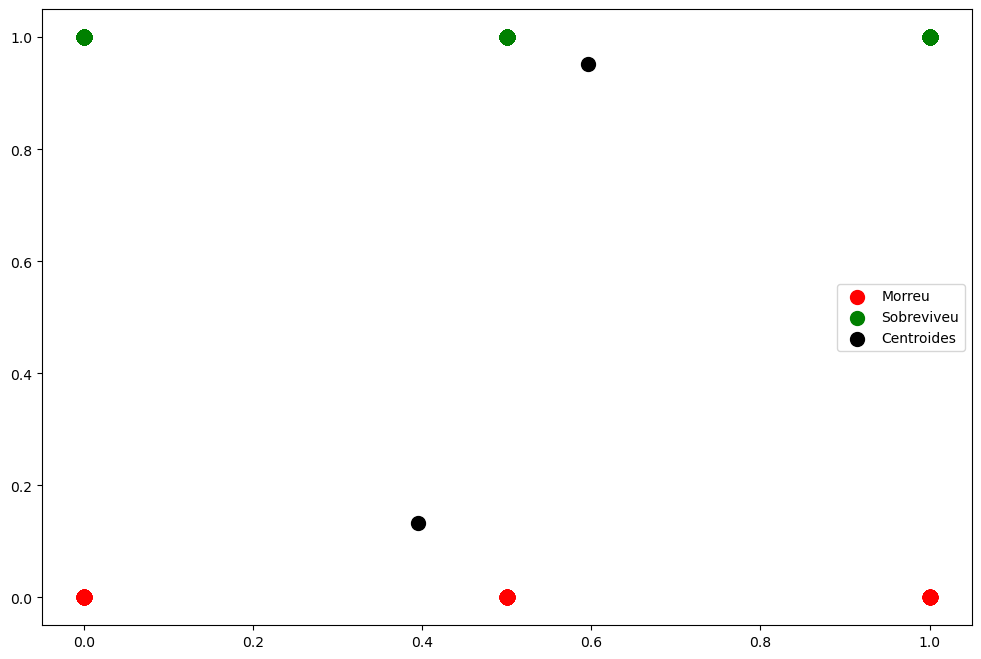

In [126]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_cmeans_titanic == 0, 0], X_titanic[y_cmeans_titanic == 0, 1], s = 100, c = "red", label = "Morreu")
plt.scatter(X_titanic[y_cmeans_titanic == 1, 0], X_titanic[y_cmeans_titanic == 1, 1], s = 100, c = "green", label = "Sobreviveu")

### OS CENTROIDES

plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

### Imprimindo o resultado dos testes - Dataset Coração

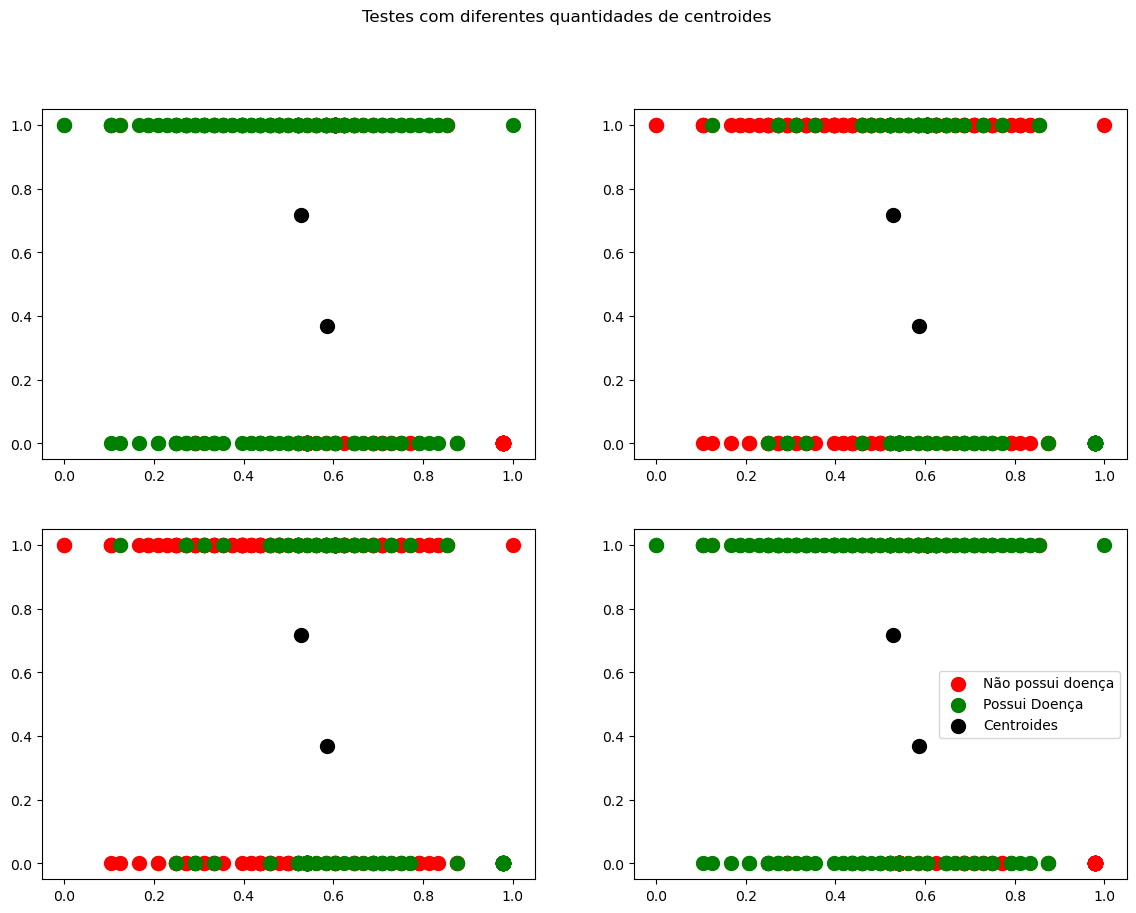

In [127]:
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = nro_de_clusters,
                 m = hiper_parametros_cmeans.getParametro_fuzzy(),
                 max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                 distance = hiper_parametros_cmeans.getDistancia(),
                 randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                 error = hiper_parametros_cmeans.getTolerancia(),
                 trained = hiper_parametros_cmeans.getModelo_treinado(),
                 n_jobs = hiper_parametros_cmeans.getNro_threads())

    cmeans.fit(X_coracao)
    y_cmeans = cmeans.predict(X_coracao)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_coracao[y_cmeans == 0, 0], X_coracao[y_cmeans == 0, 1], s = 100, c = "red", label = "Não possui doença")
    eixos[j][k].scatter(X_coracao[y_cmeans == 1, 0], X_coracao[y_cmeans == 1, 1], s = 100, c = "green", label = "Possui Doença")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, nenhum valor descreve melhor o conjunto dos pontos.
Mas será escolhido 2 como parâmetro para futuros testes no modelo, pois já sabemos que há 2 clusters

### Implementando a clusterização - Dataset Coração

In [128]:
nro_de_clusters = 2

cmeans_coracao = FCM(n_clusters = nro_de_clusters,
                  m = hiper_parametros_cmeans.getParametro_fuzzy(),
                  max_iter = hiper_parametros_cmeans.getNro_maximo_iteracoes(),
                  distance = hiper_parametros_cmeans.getDistancia(),
                  randon_seed = hiper_parametros_cmeans.getSemente_randomica(),
                  error = hiper_parametros_cmeans.getTolerancia(),
                  trained = hiper_parametros_cmeans.getModelo_treinado(),
                  n_jobs = hiper_parametros_cmeans.getNro_threads())

cmeans_coracao.fit(X_coracao)
y_cmeans_coracao = cmeans_coracao.predict(X_coracao)
centros_coracao = cmeans_coracao.centers

##### Visualizando os clusters

###### De forma 2D

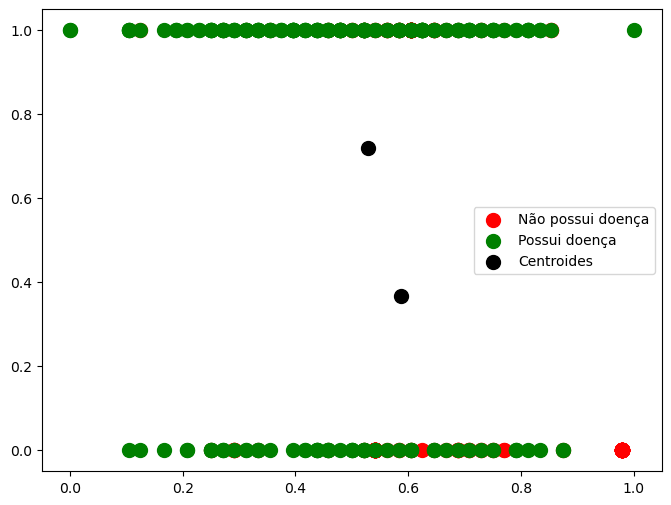

In [130]:
plt.figure(figsize = (8, 6))

### OS PONTOS GERAIS
plt.scatter(X_coracao[y_cmeans_coracao == 0, 0], X_coracao[y_cmeans_coracao == 0, 1], s = 100, c = "red", label = "Não possui doença")
plt.scatter(X_coracao[y_cmeans_coracao == 1, 0], X_coracao[y_cmeans_coracao == 1, 1], s = 100, c = "green", label = "Possui doença")

### OS CENTROIDES

plt.scatter(centros_coracao[:, 0], centros_coracao[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

## Bibliografia

### SCIKIT-LEARN
- https://scikit-learn.org/stable/

### SCIKIT-LEARN.KMEANS
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### SCIKIT-LEARN.MEANSHIFT
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
- https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html

### FUZZY_C_MEANS
- https://pypi.org/project/fuzzy-c-means/
	- https://github.com/omadson/fuzzy-c-means
- https://github.com/ShristiK/Fuzzy-C-Means-Clustering
- https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
- https://www.kaggle.com/code/prateekk94/fuzzy-c-means-clustering-on-iris-dataset
- https://fda.readthedocs.io/en/latest/index.html
	- https://fda.readthedocs.io/en/latest/modules/ml/autosummary/skfda.ml.clustering.FuzzyCMeans.html
